Trabajo Autónomo II: Minería de Flujos de Datos
===========
***Series Temporales y Minería de Flujos de Datos***

***Máster en Ciencia de Datos e Ingeniería de Computadores***

**Autor:** *Miguel Ángel Roldán Carmona*

**Correo:** *miguelroldanc@correo.ugr.es*

---

# Problema 1: Elec2

El dataset Elec2 (incluido en river.datasets) contiene la evolución del precio de la electricidad en New South Wales (Australia). El mercado de la electricidad en Australia es abierto, de modo que los precios no son fijos y se ven afectados por la demanda y la producción. El precio de la electricidad se establece a un nuevo valor cada 5 minutos. El objetivo es conocer si el precio de la electricidad subirá o bajará.

## Lectura del conjunto de datos

In [1]:
from river import datasets

data = datasets.Elec2()
print(data)

Electricity prices in New South Wales.

This is a binary classification task, where the goal is to predict if the price of electricity
will go up or down.

This data was collected from the Australian New South Wales Electricity Market. In this market,
prices are not fixed and are affected by demand and supply of the market. They are set every
five minutes. Electricity transfers to/from the neighboring state of Victoria were done to
alleviate fluctuations.

      Name  Elec2                                                      
      Task  Binary classification                                      
   Samples  45,312                                                     
  Features  8                                                          
    Sparse  False                                                      
      Path  /home/miguel/river_data/Elec2/electricity.csv              
       URL  https://maxhalford.github.io/files/datasets/electricity.zip
      Size  2.95 MB                

Podemos destacar varios elementos del resumen:

* Es un problema de clasificación binaria. El objetivo es predecir si el precio de la electricidad subirá o bajará.
* Hay un total de 45,312 instancias.
* Tiene un total de 8 atributos.
* Escaso: falso. Esto quiere decir que la mayoría de los valores que toman las variables son diferentes a 0.

A continuación vemos la estructura de cada entrada de datos.

In [2]:
data_iter = iter(data)
samples = data.n_samples
x,y = next(data_iter)
print('Entrada: \n{}\n\nSalida: {}\n\nNumber of samples: {}'.format(x, y, samples))

Entrada: 
{'date': 0.0, 'day': 2, 'period': 0.0, 'nswprice': 0.056443, 'nswdemand': 0.439155, 'vicprice': 0.003467, 'vicdemand': 0.422915, 'transfer': 0.414912}

Salida: True

Number of samples: 45312


**Información de los atributos de entrada:**
* date: fecha desde el 7 de mayo de 1996 hasta el 5 de diciembre de 1998.
* day: día de la semana.
* period: tiempo de la medida (1-48) en intervalos de media hora cada 24 horas.
* nswprice: precio de la electricidad en New South Wales.
* nswdemand: demanda de electricidad en New South Wales.
* vicprice: precio de la electricidad en Victoria.
* vicdemand: demanda de electricidad en Victoria.
* transfer: transferencia eléctrica programada entre ambos estados.

## Preprocesamiento

Para el preprocesamiento se prueba a hacer selección de los atributos nswprice, nwsdemand, vicprice, vicdemand y transfer, excluyendo atributos relacionados con el tiempo de la medición.

## Modelos

Primero definimos el esquema general de los experimentos que llevamos a cabo para los modelos.

In [3]:
def Experimento(stream, model, metric):
    history = []
    for x,y in stream:
        out = model.predict_one(x)
        model.learn_one(x,y)
        metric.update(y, out)
        history.append(metric.get())

    return history

### Regresión linear

Definimos los modelos (uno con FSS y otro con todos los atributos). De esta forma podemos ver como crear modelos como una secuencia de pasos o como una tubería.

In [4]:
from river.linear_model import LogisticRegression
from river.preprocessing import StandardScaler
from river import compose
from river import metrics
import matplotlib.pyplot as plt

seed = 2023

# Organizamos el modelo en una secuencia de pasos
lr = compose.Select('nswprice','nswdemand','vicprice','vicdemand','transfer')
lr |= StandardScaler()
lr |= LogisticRegression()

# Definimos el modelo como una pipeline
lr_full = compose.Pipeline(
    StandardScaler(),
    LogisticRegression()
)

Precisión media (fss):  0.8161193502824858

Precisión media:  0.837349929378531


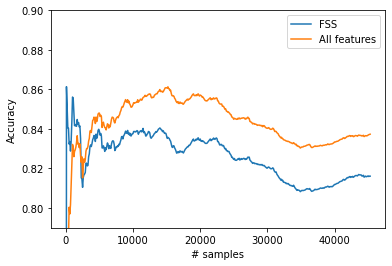

In [5]:
acc_fss = metrics.Accuracy()
history = Experimento(data, lr, acc_fss)
acc_full = metrics.Accuracy()
history2 = Experimento(data, lr_full, acc_full)
steps = 100
samp = range(0, len(history), steps)
history = history[::steps]
history2 = history2[::steps]


print('Precisión media (fss): ', acc_fss.get())
print('\nPrecisión media: ', acc_full.get())

plt.plot(samp, history)
plt.plot(samp, history2)
plt.ylabel('Accuracy')
plt.xlabel('# samples')
plt.ylim(0.79,0.9)
plt.legend(['FSS','All features'])
plt.show()

La precisión tiende a empeorar en ambos casos cuando crece el número de muestras. Se obtienen mejores resultados cuando se tienen en cuenta que día y momento de la medición que cuando solo se tienen datos del precio y la demanda.

### Árboles Hoeffding

In [6]:
from river.tree import HoeffdingTreeClassifier

# Organizamos el modelo en una secuencia de pasos
htc = compose.Select('nswprice','nswdemand','vicprice','vicdemand','transfer')
htc |= StandardScaler()
htc |= HoeffdingTreeClassifier()

# Definimos el modelo como una pipeline
htc_full = compose.Pipeline(
    StandardScaler(),
    HoeffdingTreeClassifier()
)

Precisión media (fss):  0.760306320621469

Precisión media:  0.7981770833333334


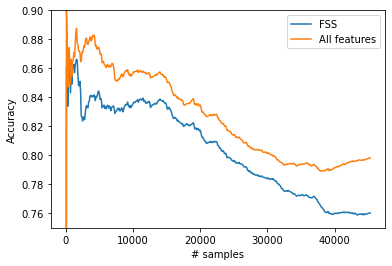

In [7]:
acc_htc = metrics.Accuracy()
history_htc = Experimento(data, htc, acc_htc)
acc_htc_full = metrics.Accuracy()
history2_htc = Experimento(data, htc_full, acc_htc_full)

samp = range(0, len(history_htc), steps)
history_htc = history_htc[::steps]
history2_htc = history2_htc[::steps]


print('Precisión media (fss): ', acc_htc.get())
print('\nPrecisión media: ', acc_htc_full.get())

plt.plot(samp, history_htc)
plt.plot(samp, history2_htc)
plt.ylabel('Accuracy')
plt.xlabel('# samples')
plt.ylim(0.75,0.9)
plt.legend(['FSS','All features'])
plt.show()

En el caso de árboles Hoeffding la precisión empeora cuando crece el número de muestras. De nuevo el modelo con todos los atributos obtiene mejores resultados.

Visualizamos el árbol generado por el mejor árbol Hoeffding (árbol con todas los atributos).

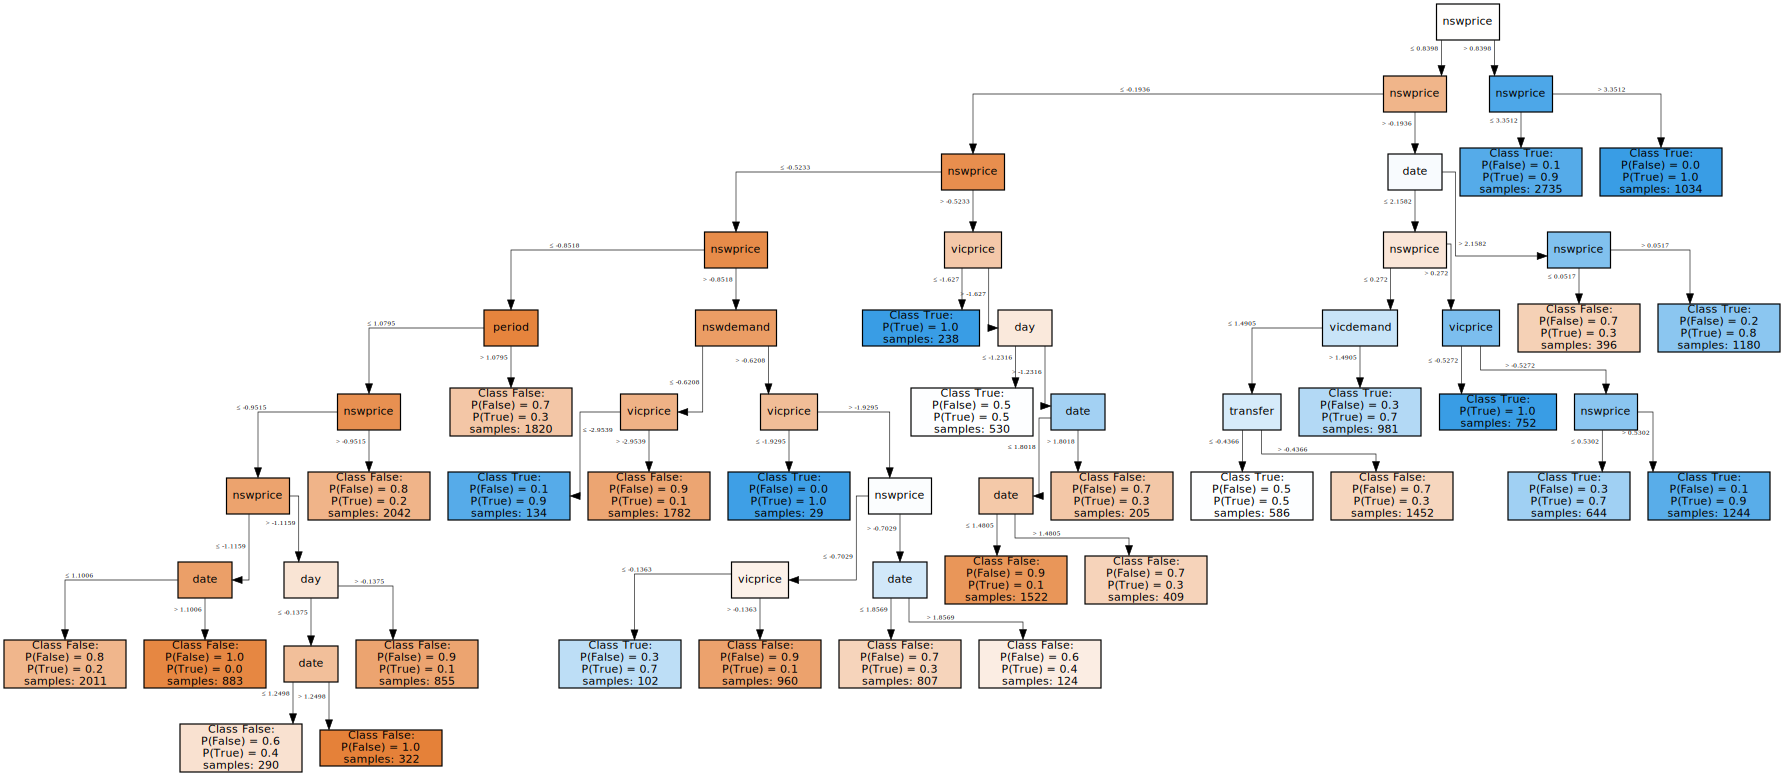

In [8]:
htc_full['HoeffdingTreeClassifier'].draw()

### Árboles Hoeffding adaptativos

Para los árboles Hoeffding adaptativos no se utiliza el modelo con selección de subconjunto de atributos debido a que en los dos modelos anteriores se obtienen peores resultados.


Precisión media:  0.8285994879943502


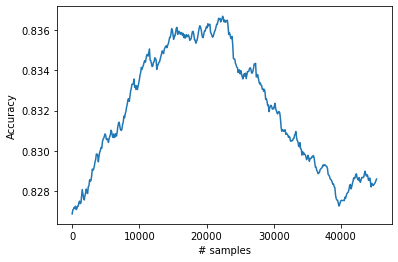

In [9]:
from river.tree import HoeffdingAdaptiveTreeClassifier
from random import seed

num_experimentos = 30
acc_hatc = metrics.Accuracy()
acc_steps = []
history_hatc = []
for i in range(num_experimentos):
    semilla = seed()
    hatc_full = compose.Pipeline(
        StandardScaler(),
        HoeffdingAdaptiveTreeClassifier(seed=semilla)
    )
    history_hatc.append(Experimento(data, hatc_full, acc_hatc))
    acc_steps.append(acc_hatc.get())

best_idx = acc_steps.index(max(acc_steps))
acc_hatc_best = acc_steps[best_idx]
hist_hatc = history_hatc[best_idx]
samp = range(0, len(hist_hatc), steps)
hist_hatc = hist_hatc[::steps]

print('\nPrecisión media: ', acc_hatc_best)
plt.plot(samp, hist_hatc)
plt.ylabel('Accuracy')
plt.xlabel('# samples')
plt.show()

En este caso el algoritmo empeora cuando crece el número de muestras, pero se aprecia una mejora entre la muestras 30000 y 40000, lo que quiere decir que este modelo es capaz de adaptarse a los cambios en los datos. Hay que tener en cuenta que el cambio que se produce es muy pequeño, del orden de las milésimas.

De forma similar al modelo anterior, visualizamos el árbol final obtenido.

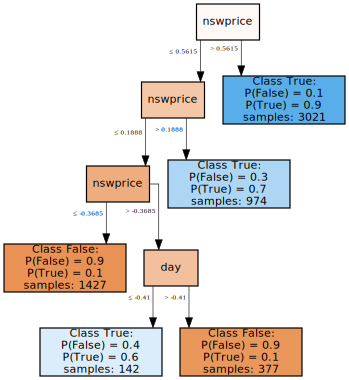

In [10]:
hatc_full['HoeffdingAdaptiveTreeClassifier'].draw()

En este caso podemos ver una estructura más clara que en el modelo no adaptativo, donde solo se seleccionan los atributos nswprice y date para realizar la predicción final.

## Comparación de modelos

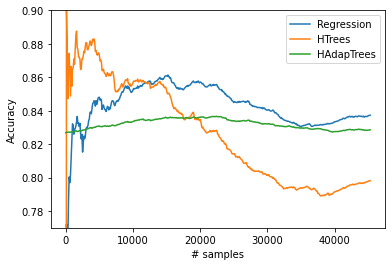


Precisión para regresión logística 0.8408775541867136

Precisión para árboles Hoeffding 0.8248010098423734

Precisión para árboles Hoeffding adaptativos 0.8319610532965471


In [11]:
import numpy as np

plt.plot(samp,history2)
plt.plot(samp,history2_htc)
plt.plot(samp,hist_hatc)
plt.ylabel('Accuracy')
plt.xlabel('# samples')
plt.ylim(0.77,0.9)
plt.legend(['Regression','HTrees','HAdapTrees'])
plt.show()

mean_lr = np.mean(history2)
mean_ht = np.mean(history2_htc)
mean_hat= np.mean(hist_hatc)

print('\nPrecisión para regresión logística', mean_lr)
print('\nPrecisión para árboles Hoeffding', mean_ht)
print('\nPrecisión para árboles Hoeffding adaptativos', mean_hat)

En la gráfica se puede ver que el modelo de regresión logística es el que mejor se adecua al problema, generando mejores valores para las muestras y una precisión mayor a los modelos basados en árboles.

Para comparar los modelos basados en árboles Hoeffding vemos el resumen para cada uno de ellos:

In [12]:
htc_full['HoeffdingTreeClassifier'].summary

{'n_nodes': 57,
 'n_branches': 28,
 'n_leaves': 29,
 'n_active_leaves': 29,
 'n_inactive_leaves': 0,
 'height': 10,
 'total_observed_weight': 45312.0}

In [13]:
hatc_full['HoeffdingAdaptiveTreeClassifier'].summary

{'n_nodes': 9,
 'n_branches': 4,
 'n_leaves': 5,
 'n_active_leaves': 20,
 'n_inactive_leaves': 0,
 'height': 5,
 'total_observed_weight': 45312.0,
 'n_alternate_trees': 25,
 'n_pruned_alternate_trees': 3,
 'n_switch_alternate_trees': 6}

In [14]:
hatc_full['HoeffdingAdaptiveTreeClassifier']

HoeffdingAdaptiveTreeClassifier (
  grace_period=200
  max_depth=inf
  split_criterion="info_gain"
  delta=1e-07
  tau=0.05
  leaf_prediction="nba"
  nb_threshold=0
  nominal_attributes=None
  splitter=GaussianSplitter (
    n_splits=10
  )
  bootstrap_sampling=True
  drift_window_threshold=300
  drift_detector=ADWIN (
    delta=0.002
    clock=32
    max_buckets=5
    min_window_length=5
    grace_period=10
  )
  switch_significance=0.05
  binary_split=False
  max_size=100.
  memory_estimate_period=1000000
  stop_mem_management=False
  remove_poor_attrs=False
  merit_preprune=True
  seed=None
)

El modelo basado en árboles Hoeffding adaptativo consigue una precisión mejor que el modelo basado en árboles Hoeffding. Además, se pueden destacar los siguientes aspectos dentro de su resumen:
* Tanto el número de nodos como el número de ramas son mucho menores en el modelo adaptativo.
* La altura del árbol necesita cuatro niveles en el modelo adaptativo frente a 10 niveles del árbol.
* Ambos árboles observan el mismo peso para el conjunto de datos.

---

# Problema 2: FriedmanDrift

El dataset *FriedmanDrift* incluido en *River* es un generador de flujos de datos con concept drift. Cada muestra tiene 10 atributos, en el rango [0,1]. Está centrado en el problema de regresión de un atributo objetivo.

El objetivo de este ejercicio es el estudio de 3 tipos distintos de Concept Drift:

* Cambio de concepto abrupto. Se produce un cambio de concepto completo centrado en las posiciones indicadas al dataset. Este cambio de concepto abrupto tiene dos modalidades:
    * Local: el cambio de concepto se produce sólo en dos regiones distintas del espacio de instancias.
    * Global: el cambio de concepto se produce en todas las regiones del espacio de instancias.
* Cambio de concepto gradual. Se produce un cambio de concepto de forma global, de forma paulatina según se especifica en el parámetro *transition_window* del generador de datos.


Para realizar este estudio, se entrenan dos modelos de regresión: uno basado en árboles Hoeffding y otro basado en árboles Hoeffding adaptativos. Para validar los modelos se utiliza la métrica MAE.

## Generación de experimentos

In [15]:
def GenerarExperimentos(data, modelo, metrica, veces=10):
    metric_steps = []
    historia = []
    metric = metrica
    for i in range(veces):
        semilla = seed()
        modelo.seed = semilla
        full_model = compose.Pipeline(
            StandardScaler(),
            modelo
        )
        historia.append(Experimento(data, modelo, metric))
        metric_steps.append(metric.get())

    best_idx = metric_steps.index(max(metric_steps))
    metric_best = metric_steps[best_idx]
    hist_best = historia[best_idx]
    
    return metric_best, hist_best

## Cambio de concepto abrupto local

In [36]:
from river.tree import HoeffdingAdaptiveTreeRegressor
from river.tree import HoeffdingTreeRegressor

hatr = HoeffdingAdaptiveTreeRegressor()
htr = HoeffdingTreeRegressor()
metrica = metrics.MAE()

drift_pos = (0,7500,15000)
tam = 30000
ventana = 2000
first_idx = 2500
flujo = datasets.synth.FriedmanDrift(drift_type='lea', position=drift_pos, seed=2023)

mae_local_hatr, local_hatr = GenerarExperimentos(flujo.take(tam), hatr, metrica)
mae_local_htr, local_htr = GenerarExperimentos(flujo.take(tam), htr, metrica)

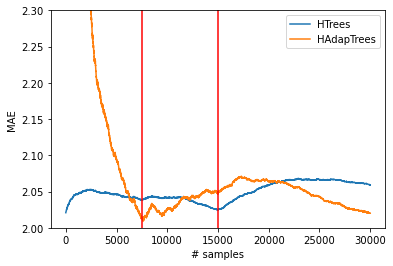


MAE para árboles Hoeffding 2.0498934830208007

MAE para árboles Hoeffding adaptativos 2.056034649995064


In [38]:
samp = range(0, len(local_hatr))
plt.plot(samp,local_htr)
plt.plot(samp,local_hatr)
plt.plot([7500,7500], [1,3], '-', color='red')
plt.plot([15000,15000], [1,3], '-', color='red')
plt.ylabel('MAE')
plt.xlabel('# samples')
plt.ylim(2,2.3)
plt.legend(['HTrees','HAdapTrees'])
plt.show()

mean_ht_reg = np.mean(local_htr[first_idx:])
mean_hat_reg = np.mean(local_hatr[first_idx:])

print('\nMAE para árboles Hoeffding', mean_ht_reg)
print('\nMAE para árboles Hoeffding adaptativos', mean_hat_reg)

Para este caso no existe una diferencia significativa entre ambos modelos. Ambos se adaptan de forma similar al cambio de concepto abrupto local, donde el MAE es prácticamente el mismo para todas las muestras. Resalta el segundo cambio de concept drift donde el modelo adaptativo necesita más muestras para mejorar el MAE.

## Cambio de concepto abrupto global

In [29]:
drift = (7500,15000)
flujo2 = datasets.synth.FriedmanDrift(drift_type='gra', position=drift, seed=2023)
hatr = HoeffdingAdaptiveTreeRegressor()
htr = HoeffdingTreeRegressor()
metrica = metrics.MAE()

mae_local_hatr, local_hatr = GenerarExperimentos(flujo2.take(tam), hatr, metrica)
mae_local_htr, local_htr = GenerarExperimentos(flujo2.take(tam), htr, metrica)

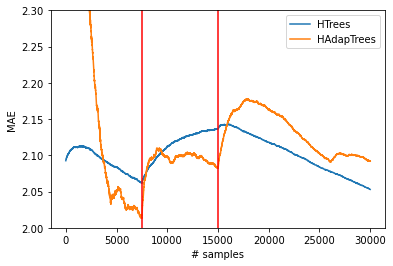


MAE para árboles Hoeffding 2.1017842853234256

MAE para árboles Hoeffding adaptativos 2.1098859962061893


In [30]:
samp = range(0, len(local_hatr))
plt.plot(samp,local_htr)
plt.plot(samp,local_hatr)
plt.plot([7500,7500], [1,3], '-', color='red')
plt.plot([15000,15000], [1,3], '-', color='red')
plt.ylabel('MAE')
plt.xlabel('# samples')
plt.legend(['HTrees','HAdapTrees'])
plt.ylim(2,2.3)
plt.show()

mean_ht_reg = np.mean(local_htr[first_idx:])
mean_hat_reg = np.mean(local_hatr[first_idx:])

print('\nMAE para árboles Hoeffding', mean_ht_reg)
print('\nMAE para árboles Hoeffding adaptativos', mean_hat_reg)

El modelo adaptativo muestra una mejora mayor en el MAE que el modelo no adaptativo cuando se produce el cambio de concepto. Para el segundo cambio de concepto el algoritmo es peor, pero también se observa que el MAE mejora de forma muy significativa, haciendo que los resultados a partir de la muestra 25000 sean similares.

## Cambio de concepto gradual

In [31]:
flujo3 = datasets.synth.FriedmanDrift(drift_type='gsg', position=drift, transition_window=ventana, seed=2023)
hatr = HoeffdingAdaptiveTreeRegressor()
htr = HoeffdingTreeRegressor()
metrica = metrics.MAE()

mae_local_hatr, local_hatr = GenerarExperimentos(flujo3.take(tam), hatr, metrica)
mae_local_htr, local_htr = GenerarExperimentos(flujo3.take(tam), htr, metrica)

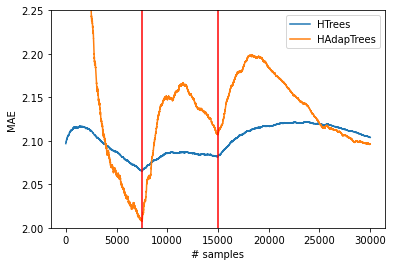


MAE para árboles Hoeffding 2.099727138708292

MAE para árboles Hoeffding adaptativos 2.1275509899832654


In [35]:
samp = range(0, len(local_hatr))
plt.plot(samp,local_htr)
plt.plot(samp,local_hatr)
plt.plot([7500,7500], [1,3], '-', color='red')
plt.plot([15000,15000], [1,3], '-', color='red')
plt.ylabel('MAE')
plt.xlabel('# samples')
plt.legend(['HTrees','HAdapTrees'])
plt.ylim(2,2.25)
plt.show()

mean_ht_reg = np.mean(local_htr[first_idx:])
mean_hat_reg = np.mean(local_hatr[first_idx:])

print('\nMAE para árboles Hoeffding', mean_ht_reg)
print('\nMAE para árboles Hoeffding adaptativos', mean_hat_reg)

Para este problema el modelo no adaptativo tiene mejores resultados, con un MAE más bajo que el modelo adaptativo después de los cambios de concepto. Finalmente el MAE para el modelo no adaptativo es mejor que para el modelo adaptativo,